In [41]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "vscode" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [12]:
data = pd.read_csv('data/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


### Train and Test sets for models

In [13]:
target_variable = 'converted'

X = data.drop(target_variable, axis=1)
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print('Target variable :', target_variable)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')
Target variable : converted



In [14]:
# Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Preprocessing

In [15]:
numeric_features = ['age', 'total_pages_visited']
categorical_features = ['new_user', 'country', 'source']

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['new_user', 'country', 'source']


In [16]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [17]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) 
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:])

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
137434   China   19         1     Seo                    1
112323      US   33         1  Direct                    5
143261      US   51         1     Ads                    2
162328   China   17         0     Seo                    1
158039   China   28         1     Seo                    5
...Done.
[[-1.3990984  -1.15935344  1.          0.          0.          0.
   0.          1.        ]
 [ 0.29299544  0.03743241  1.          0.          0.          1.
   1.          0.        ]
 [ 2.46854467 -0.86015697  1.          0.          0.          1.
   0.          0.        ]
 [-1.64082609 -1.15935344  0.          0.          0.          0.
   0.          1.        ]
 [-0.31132378  0.03743241  1.          0.          0.          0.
   0.          1.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
138303      UK   34         

## Performance assessment 
- f1_score, cross_val_score, confusion matrices, Feature Importance and Classification report

In [18]:
def evaluate_performance(model):
  Y_train_pred = model.predict(X_train)
  Y_test_pred = model.predict(X_test)

  # Here, the f1-score will be used to assess the performances on the leaderboard
  print(model.__class__.__name__)
  print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
  print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
  print()
  
  scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='f1')
  print('The cross-validated f1 score is : ', scores.mean())
  print('The standard deviation is : ', scores.std())
  print('is this model overfitting ? ', f1_score(Y_test, Y_test_pred) - f1_score(Y_train, Y_train_pred) > scores.std())

  # Visualize confusion matrices
  _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
  axes[0].set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, ax=axes[0]) # ConfusionMatrixDisplay from sklearn

  axes[1].set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=axes[1]) # ConfusionMatrixDisplay from sklearn
  plt.show()

  # Feature Importance
  # numeric_features +  encoded categorical column names
  columns = np.append(numeric_features, preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(categorical_features))
  try:
    coefs = pd.DataFrame(index=columns, data=model.coef_.transpose(), columns=['coefficients'] )
    # Compute abs() and sort values
    feature_importance = abs(coefs).sort_values(by = 'coefficients')
    # Plot coefficients
    fig = px.bar(feature_importance, orientation = 'h', title='Feature Importance')
    fig.update_layout(showlegend = False, 
                      margin = {'l': 120} # to avoid cropping of column names
                      )
    fig.show()
  except:
    pass

  # Classification report
  print('classification_report on Train set')
  print(classification_report(Y_train,Y_train_pred))
  print('---')
  print('classification_report on Test set')
  print(classification_report(Y_test,Y_test_pred))

In [19]:
def get_f1_score(model):
  Y_train_pred = model.predict(X_train)
  Y_test_pred = model.predict(X_test)

  # Here, the f1-score will be used to assess the performances on the leaderboard
  print(model.__class__.__name__)
  print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
  print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

## Model

#### **Bagging**

##### RandomForest (with hyperparameter optimization)

In [36]:
# Perform grid search
print("Grid search...")
random_forest = RandomForestClassifier()

# Grid of values to be tested
params = {
    # 'max_depth': [10, 100, 1000],
    # 'min_samples_leaf': [5, 10, 15],
    # 'min_samples_split': [5, 10, 15],
    # 'n_estimators': [1, 10, 100]

    # on réduit à
    'max_depth': [1200, 1250, 1300],
    'min_samples_leaf': [14, 15, 16],
    'min_samples_split': [3, 5, 8],
    'n_estimators': [75, 100, 125]
}
print(params)
random_forest_opt = GridSearchCV(random_forest, param_grid = params, cv = 3, verbose = 3, n_jobs=-1, scoring='f1') 
# cv : the number of folds to be used for CV
random_forest_opt.fit(X_train, Y_train)
print("...Done.")
print()
get_f1_score(random_forest_opt)

Grid search...
{'max_depth': [1200, 1250, 1300], 'min_samples_leaf': [14, 15, 16], 'min_samples_split': [3, 5, 8], 'n_estimators': [75, 100, 125]}
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END max_depth=1200, min_samples_leaf=14, min_samples_split=3, n_estimators=75;, score=0.753 total time=   8.1s
[CV 3/3] END max_depth=1200, min_samples_leaf=14, min_samples_split=3, n_estimators=75;, score=0.764 total time=   8.2s
[CV 2/3] END max_depth=1200, min_samples_leaf=14, min_samples_split=3, n_estimators=75;, score=0.761 total time=   8.2s
[CV 3/3] END max_depth=1200, min_samples_leaf=14, min_samples_split=3, n_estimators=100;, score=0.766 total time=  10.8s
[CV 2/3] END max_depth=1200, min_samples_leaf=14, min_samples_split=3, n_estimators=100;, score=0.764 total time=  10.8s
[CV 1/3] END max_depth=1200, min_samples_leaf=14, min_samples_split=3, n_estimators=100;, score=0.754 total time=  10.9s
[CV 1/3] END max_depth=1200, min_samples_leaf=14, min_samples_split=

In [37]:
print("Best hyperparameters : ", random_forest_opt.best_params_)
print("Best validation accuracy : ", random_forest_opt.best_score_)

Best hyperparameters :  {'max_depth': 1200, 'min_samples_leaf': 14, 'min_samples_split': 8, 'n_estimators': 125}
Best validation accuracy :  0.7639404198475939


RandomForestClassifier
f1-score on train set :  0.7733953209358129
f1-score on test set :  0.7446744674467446

The cross-validated f1 score is :  0.76246159473684
The standard deviation is :  0.007319396031508183
is this model overfitting ?  False


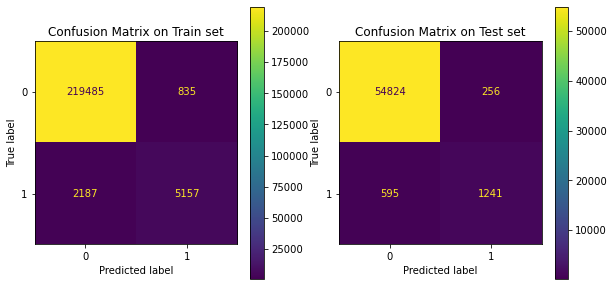

classification_report on Train set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.86      0.70      0.77      7344

    accuracy                           0.99    227664
   macro avg       0.93      0.85      0.88    227664
weighted avg       0.99      0.99      0.99    227664

---
classification_report on Test set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.83      0.68      0.74      1836

    accuracy                           0.99     56916
   macro avg       0.91      0.84      0.87     56916
weighted avg       0.98      0.99      0.98     56916



In [38]:
evaluate_performance(random_forest_opt.best_estimator_)

## Submission

In [25]:
def retrain_and_submit(model, version=1):
  print(model)
  # Concatenate our train and test set to train your best classifier on all data with labels
  X = np.append(X_train,X_test,axis=0)
  Y = np.append(Y_train,Y_test)

  model.fit(X,Y)

  # Read data without labels
  data_without_labels = pd.read_csv('data/conversion_data_test.csv')
  print('Prediction set (without labels) :', data_without_labels.shape)

  # apply the preprocessing
  X_without_labels = preprocessor.transform(data_without_labels)
  data = {
    'converted': model.predict(X_without_labels)
  }

  Y_predictions = pd.DataFrame(columns=['converted'],data=data)
  Y_predictions.to_csv(f'submissions/conversion_data_test_predictions_Alexon_V{version}.csv', index=False)
  print('Done ....')

In [26]:
retrain_and_submit(random_forest_opt.best_estimator_, version=16)

RandomForestClassifier(max_depth=90, min_samples_leaf=5, min_samples_split=12,
                       n_estimators=300)
Prediction set (without labels) : (31620, 5)
Done ....


In [39]:
retrain_and_submit(random_forest_opt.best_estimator_, version=20)

RandomForestClassifier(max_depth=1200, min_samples_leaf=14, min_samples_split=8,
                       n_estimators=125)
Prediction set (without labels) : (31620, 5)
Done ....


In [40]:
get_f1_score(random_forest_opt.best_estimator_)

RandomForestClassifier
f1-score on train set :  0.7726896759154824
f1-score on test set :  0.759843703035768


In [42]:
pickle.dump(random_forest_opt.best_estimator_, open('models/random_forest_opt_v_20', 'wb'))